## Clinical scores

This notebook processes the raw clinical scores into the merged format downloadable from the proteingym website. To recompute the 
stats using the downloaded file, use get_clinical_stats.ipynb

In [ ]:
from glob import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm
tqdm.pandas()


pd.set_option('display.max_columns', None)

In [2]:
ROOT = "/n/groups/marks/projects/marks_lab_and_oatml/ProteinGym/"  # Change this to the root of the repo
# Inputs
model_scores_folder = f"{ROOT}/model_scores/zero_shot_clinical_substitutions/"
clinvar_variants = f"{ROOT}/Clinical_datasets/clinvar_proteingym_20230611.GRCh38_filter_isoform_clean.csv"
clinvar_mapping = f"{ROOT}/Clinical_datasets/clinical_substitutions_mapping_by_refseq_filter_isoform.csv"
dbnsfp_output = f"{ROOT}/Clinical_datasets/dbnsfp_44a/clinvar_proteingym_20230611.GRCh38_filter_isoform_clean.dbSNFP_out.txt"

# Outputs
dbnsfp_clean_file = f"{ROOT}/Clinical_datasets/notebooks/processed_data/clinvar/dbnsfp_clean_clinvar_proteingym_20230611.GRCh38_filter_isoform_clean.csv"
merged_zero_shot_clinical = f"{ROOT}/Clinical_datasets/notebooks/processed_data/clinvar/baseline_models_clinvar_merged.csv"
merged_models_file = f"{ROOT}/Clinical_datasets/notebooks/processed_data/clinvar/all_models_clinvar_proteingym_20230611.GRCh38_filter_isoform_clean.csv"
merged_models_deduplicated = f"{ROOT}/Clinical_datasets/notebooks/processed_data/clinvar/all_models_deduplicated_scores_clinvar_proteingym_20230611.GRCh38_filter_isoform_clean.csv"
clinical_scores_file = f"{ROOT}/Clinical_datasets/2023_12_05_clinical_substitutions_scores.csv"
clinical_rankings_file = f"{ROOT}/Clinical_datasets/2023_12_05_clinical_substitutions_AUC_rankings.csv"

## Constants

In [3]:
# All of these are folders in ProteinGym/model_scores/zero_shot_clinical_substitutions
model_cols = {
    "ESM1b": "esm1b_t33_650M_UR50S",
    "EVE": "evol_indices", 
    "GEMME": "GEMME_score", 
    "TranceptEVE/TranceptEVE_L": "avg_score",
}
new_model_cols = {
    "ESM1b": "ESM1b",
    "EVE": "EVE",
    "TranceptEVE/TranceptEVE_L": "TranceptEVE",
    "GEMME": "GEMME",
}


db_nsfp_models = [
    # New after reading review paper:
    "MetaRNN_score",
    "SIFT4G_score",
    # New ones:
    "REVEL_score",
    "BayesDel_addAF_score",  # Could also use noAF
    "BayesDel_noAF_score",
    "PrimateAI_score",
    "ClinPred_score", 
    "VARITY_R_LOO_score",
    "VARITY_ER_LOO_score",
    "gMVP_score",
    "VEST4_score",
    # Previous
    "CADD_phred",  # Could also use CADD_RAW
    "Polyphen2_HDIV_score", 
    "Polyphen2_HVAR_score",
    "DEOGEN2_score",
    "SIFT_score",
    "PROVEAN_score",
    "MutationAssessor_score",
    "MPC_score",
    "MutPred_score",
    "PrimateAI_score",
    "LIST-S2_score",
    "DANN_score",
    "LRT_score",
    "FATHMM_score",
    "MutationTaster_converted_rankscore",
]
score_directionality_flip = ["LRT_score", "FATHMM_score", "SIFT_score", "PROVEAN_score", "SIFT4G_score"]

## Merge all models together into one big CSV

### Read our full clinvar file

In [4]:
df_clinvar_ref = pd.read_csv(clinvar_mapping)
df_clinvar_ref.head()

,DMS_id,target_seq,DMS_filename
0,NP_000007.1,MAAGFGRCCRVLRSISRFHWRSQHTKANRQREPGLGFSFEFTEQQK...,NP_000007.1.csv
1,NP_000008.1,MAAALLARASGPARRALCPRAWRQLHTIYQSVELPETHQMLLQTCR...,NP_000008.1.csv
2,NP_000009.1,MQAARMAASLGRQLLRLGGGSSRLTALLGQPRPGPARRPYAGGAAQ...,NP_000009.1.csv
3,NP_000010.1,MAVLAALLRSGARSRSPLLRRLVQEIRYVERSYVSKPTLKEVVIVS...,NP_000010.1.csv
4,NP_000011.2,MTLGSPRKGLLMLLMALVTQGDPVKPSRGPLVTCTCESPHCKGPTC...,NP_000011.2.csv


In [5]:
df_clinvar = pd.read_csv(clinvar_variants)
print(len(df_clinvar))
df_clinvar.head()

62780


/tmp/ipykernel_32174/2195891957.py:1: DtypeWarning: Columns (0,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_clinvar = pd.read_csv(clinvar_variants)


,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,#Uploaded_variation,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,IMPACT,DISTANCE,STRAND,FLAGS,REFSEQ_MATCH,REFSEQ_OFFSET,GIVEN_REF,USED_REF,BAM_EDIT,HGVSc,HGVSp,HGVS_OFFSET,protein,AF_ESP,AF_EXAC,ALLELEID,CLNDISDB,CLNDN,CLNHGVS,CLNREVSTAT,CLNSIG,CLNSIGCONF,CLNVC,CLNVCSO,GENEINFO,MC,ORIGIN,RS,AF_TGP,CLNVI,CLNDISDBINCL,CLNDNINCL,CLNSIGINCL,mutant,EVH_epistatic,EVH_independent,ESM1V_ensemble_mean,Tranception,model_count,clinsig,protein_sequence,mutated_sequence,ClinSigSimple
0,1,1020183,387476,G,C,.,PASS,387476,1:1020183,C,375790,NM_198576.4,Transcript,missense_variant,64,11,4,R/P,cGg/cCg,-,MODERATE,-,1,-,-,-,G,G,-,NM_198576.4:c.11G>C,NP_940978.2:p.Arg4Pro,-,NP_940978.2,NaN,0.00114,364282,"MONDO:MONDO:0014052,MedGen:C3808739,OMIM:61512...",Congenital_myasthenic_syndrome_8|not_provided,NC_000001.11:g.1020183G>C,"criteria_provided,_multiple_submitters,_no_con...",Benign,NaN,single_nucleotide_variant,SO:0001483,AGRN:375790,SO:0001583|missense_variant,1,539283387,0.00958,ClinGen:CA507760,NaN,NaN,NaN,R4P,NaN,NaN,0.180347,NaN,3,benign,MAGRSHPGPLRPLLPLLVVAACVLPGAGGTCPERALERREEEANVV...,MAGPSHPGPLRPLLPLLVVAACVLPGAGGTCPERALERREEEANVV...,Benign
1,1,1020297,774056,A,C,.,PASS,774056,1:1020297,C,375790,NM_198576.4,Transcript,missense_variant,178,125,42,E/A,gAg/gCg,-,MODERATE,-,1,-,-,-,A,A,-,NM_198576.4:c.125A>C,NP_940978.2:p.Glu42Ala,-,NP_940978.2,NaN,0.00036,695921,"MONDO:MONDO:0014052,MedGen:C3808739,OMIM:61512...",Congenital_myasthenic_syndrome_8,NC_000001.11:g.1020297A>C,"criteria_provided,_single_submitter",Likely_benign,NaN,single_nucleotide_variant,SO:0001483,AGRN:375790,SO:0001583|missense_variant,1,757604648,NaN,NaN,NaN,NaN,NaN,E42A,NaN,NaN,0.353416,NaN,3,likely_benign,MAGRSHPGPLRPLLPLLVVAACVLPGAGGTCPERALERREEEANVV...,MAGRSHPGPLRPLLPLLVVAACVLPGAGGTCPERALERREEAANVV...,Benign
2,1,1022225,243036,G,A,.,PASS,243036,1:1022225,A,375790,NM_198576.4,Transcript,missense_variant,279,226,76,G/S,Ggc/Agc,-,MODERATE,-,1,-,-,-,G,G,-,NM_198576.4:c.226G>A,NP_940978.2:p.Gly76Ser,-,NP_940978.2,NaN,0.00001,244110,"MONDO:MONDO:0018940,MeSH:D020294,MedGen:C07518...",Congenital_myasthenic_syndrome|Congenital_myas...,NC_000001.11:g.1022225G>A,"criteria_provided,_single_submitter",Likely_pathogenic,NaN,single_nucleotide_variant,SO:0001483,AGRN:375790|LOC126805576:126805576,SO:0001583|missense_variant,1,756623659,NaN,ClinGen:CA507784,NaN,NaN,NaN,G76S,NaN,NaN,-0.679921,NaN,3,likely_path,MAGRSHPGPLRPLLPLLVVAACVLPGAGGTCPERALERREEEANVV...,MAGRSHPGPLRPLLPLLVVAACVLPGAGGTCPERALERREEEANVV...,Pathogenic
3,1,1022383,541203,C,G,.,PASS,541203,1:1022383,G,375790,NM_198576.4,Transcript,missense_variant,437,384,128,H/Q,caC/caG,-,MODERATE,-,1,-,-,-,C,C,-,NM_198576.4:c.384C>G,NP_940978.2:p.His128Gln,-,NP_940978.2,NaN,0.00076,514916,"MONDO:MONDO:0014052,MedGen:C3808739,OMIM:61512...",Congenital_myasthenic_syndrome_8,NC_000001.11:g.1022383C>G,"criteria_provided,_single_submitter",Likely_benign,NaN,single_nucleotide_variant,SO:0001483,AGRN:375790|LOC126805576:126805576,SO:0001583|missense_variant,1,768527925,NaN,ClinGen:CA507813,NaN,NaN,NaN,H128Q,NaN,NaN,0.594910,NaN,3,likely_benign,MAGRSHPGPLRPLLPLLVVAACVLPGAGGTCPERALERREEEANVV...,MAGRSHPGPLRPLLPLLVVAACVLPGAGGTCPERALERREEEANVV...,Benign
4,1,1035307,474141,C,T,.,PASS,474141,1:1035307,T,375790,NM_198576.4,Transcript,missense_variant,547,494,165,P/L,cCt/cTt,-,MODERATE,-,1,-,-,-,C,C,-,NM_198576.4:c.494C>T,NP_940978.2:p.Pro165Leu,-,NP_940978.2,0.00192,0.00059,446942,"MONDO:MONDO:0014052,MedGen:C3808739,OMIM:61512...",Congenital_myasthenic_syndrome_8|not_provided,NC_000001.11:g.1035307C>T,"criteria_provided,_multiple_submitters,_no_con...",Likely_benign,NaN,single_nucleotide_variant,SO:0001483,AGRN:375790,SO:0001583|missense_variant,1,140954236,0.00300,ClinGen:CA507857,NaN,NaN,NaN,P165L,NaN,NaN,-1.053310,NaN,3,likely_benign,MAGRSHPGPLRPLLPLLVVAACVLPGAGGTCPERALERREEEANVV...,MAGRSHPGPLRPLLPLLVVAACVLPGAGGTCPERALERR

In [6]:
# Sanity check, useful for later: Check that the merged variants file contains all the proteins in the reference file
assert set(df_clinvar["protein"].unique()) == set(df_clinvar_ref["DMS_id"].unique())

In [7]:
# Check duplicates
print(df_clinvar.duplicated(subset=["#CHROM", "POS", "REF", "ALT"]).sum())
print(df_clinvar.duplicated(subset=["mutant", "protein"]).sum())  # 496: This should actually be averaged out
print(df_clinvar.duplicated(subset=["#CHROM", "POS", "REF", "ALT", "mutant", "protein"]).sum())  # This is the ideal combination, if models have this

# No duplicates with different benign/pathogenic annotations at least:
assert (df_clinvar[df_clinvar.duplicated(subset=["mutant", "protein"], keep=False)].groupby(["mutant", "protein"])["ClinSigSimple"].nunique() == 1).all()

df_clinvar[df_clinvar.duplicated(subset=["mutant", "protein"], keep=False)]  # Note: Why are these duplicates here?

158
0
0


,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,#Uploaded_variation,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,IMPACT,DISTANCE,STRAND,FLAGS,REFSEQ_MATCH,REFSEQ_OFFSET,GIVEN_REF,USED_REF,BAM_EDIT,HGVSc,HGVSp,HGVS_OFFSET,protein,AF_ESP,AF_EXAC,ALLELEID,CLNDISDB,CLNDN,CLNHGVS,CLNREVSTAT,CLNSIG,CLNSIGCONF,CLNVC,CLNVCSO,GENEINFO,MC,ORIGIN,RS,AF_TGP,CLNVI,CLNDISDBINCL,CLNDNINCL,CLNSIGINCL,mutant,EVH_epistatic,EVH_independent,ESM1V_ensemble_mean,Tranception,model_count,clinsig,protein_sequence,mutated_sequence,ClinSigSimple


### Read model scores and merge together

If the model has ["#CHROM", "POS", "REF", "ALT"] in the columns, merge on these (more precise), otherwise merge on ["mutant", "protein"]

In [8]:
if os.path.isfile(merged_zero_shot_clinical):
    df_merged = pd.read_csv(merged_zero_shot_clinical, low_memory=False).astype({"#CHROM": str})  # Remember to keep #CHROM as str
else:
    df_merged = df_clinvar.copy().astype({"#CHROM": str})
    print("Length of df_clinvar:", len(df_merged))
    eve_mutated_sequence_dfs = []
    for model in model_cols.keys():
        print(model)
        # Read all the CSV files and concatenate together (will left-join this with the clinvar file)
        model_path = f"{model_scores_folder}/{model}/"
        assert os.path.isdir(model_path)
        print(model_path)
        dfs = []
        dfs_full = []
        score_col = model_cols[model]
        
        matching_files = glob(model_path+"/*.csv")
        assert len(matching_files) > 0
        skipped_files = []
        for file in tqdm(matching_files):
            if os.path.basename(file) not in set(df_clinvar_ref["DMS_filename"]):
                skipped_files.append(os.path.basename(file))
                continue
            tmp_df = pd.read_csv(file)
            
            if model == "EVE":
                if "mutant" not in tmp_df.columns and "mutations" in tmp_df.columns:
                    tmp_df = tmp_df.rename(columns={"mutations": "mutant"})
                # After renaming
                if score_col not in tmp_df.columns:
                    tmp_df = tmp_df.rename(columns={"EVE_evol_index": score_col, "evol_indices_seed_0": score_col})  # There are three different sources of EVE models: Invitae, popEVE and latest runs
            
            if not set(("mutant", score_col)) <= set(tmp_df.columns):  # don't really need "mutated_sequence"
                skipped_files.append(os.path.basename(file))
                print("Error in score column, skipping:", os.path.basename(file), tmp_df.columns)
                continue

            # Add RefSeq column if not there yet
            if "protein" not in tmp_df.columns:
                tmp_df["protein"] = os.path.basename(file).split(".csv")[0]
            
            # Try add extra info if possible
            if set(["#CHROM", "POS", "REF", "ALT"]) <= set(tmp_df.columns):
                dfs.append(tmp_df[["#CHROM", "POS", "REF", "ALT", score_col, "mutant", "protein"]])
            else:    
                tmp_df[["#CHROM", "POS", "REF", "ALT"]] = np.NaN  # Leave these empty
                dfs.append(tmp_df[[score_col, "mutant", "protein"]])  # "mutated_sequence", 
        
        print(f"{len(dfs)+len(dfs_full)} matching files found")
        df = pd.concat(dfs)
        assert (~df[score_col].isna()).sum() > 0
        print(f"{model} Length before merging:", len(df))
        print(f"{model} columns: {df.columns}")
        
        # Simple (but possibly duplicates):
        # df_merged = df_merged.merge(df, on=["mutant", "protein"], how="left")
        
        # Now also cast df CHROM to string
        df = df.astype({"#CHROM": str})
        
        df_merged = df_merged.merge(df[~df[["#CHROM", "POS", "REF", "ALT"]].isna().any(axis=1)], on=["#CHROM", "POS", "REF", "ALT", "mutant", "protein"], how="left")
        df_merged = df_merged.merge(df[df[["#CHROM", "POS", "REF", "ALT"]].isna().any(axis=1)][["mutant", "protein", score_col]], on=["mutant", "protein"], how="left")
        
        # Reconcile score columns
        assert df_merged[~df_merged[f"{score_col}_x"].isna()][f"{score_col}_y"].isna().all()  # No clash from left to right
        assert df_merged[~df_merged[f"{score_col}_y"].isna()][f"{score_col}_x"].isna().all()  # No clash from right to left
        # Merge into one column
        df_merged.loc[~df_merged[f"{score_col}_x"].isna(), score_col] = df_merged.loc[~df_merged[f"{score_col}_x"].isna(), f"{score_col}_x"]
        df_merged.loc[~df_merged[f"{score_col}_y"].isna(), score_col] = df_merged.loc[~df_merged[f"{score_col}_y"].isna(), f"{score_col}_y"]
        df_merged = df_merged.drop([f"{score_col}_x", f"{score_col}_y"], axis=1)
        # Rename score columns
        print(f"{(~df_merged[score_col].isna()).sum()} scores after merging")
        df_merged = df_merged.rename(columns={score_col: new_model_cols[model]})
        print("df_merged length after merging:", len(df_merged))
    df_merged.to_csv(merged_zero_shot_clinical)
    
display(df_merged)

,Unnamed: 0,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,#Uploaded_variation,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,IMPACT,DISTANCE,STRAND,FLAGS,REFSEQ_MATCH,REFSEQ_OFFSET,GIVEN_REF,USED_REF,BAM_EDIT,HGVSc,HGVSp,HGVS_OFFSET,protein,AF_ESP,AF_EXAC,ALLELEID,CLNDISDB,CLNDN,CLNHGVS,CLNREVSTAT,CLNSIG,CLNSIGCONF,CLNVC,CLNVCSO,GENEINFO,MC,ORIGIN,RS,AF_TGP,CLNVI,CLNDISDBINCL,CLNDNINCL,CLNSIGINCL,mutant,EVH_epistatic,EVH_independent,ESM1V_ensemble_mean,Tranception,model_count,clinsig,protein_sequence,mutated_sequence,ClinSigSimple,ESM1b,EVE,GEMME,TranceptEVE
0,0,1,1020183,387476,G,C,.,PASS,387476,1:1020183,C,375790,NM_198576.4,Transcript,missense_variant,64,11,4,R/P,cGg/cCg,-,MODERATE,-,1,-,-,-,G,G,-,NM_198576.4:c.11G>C,NP_940978.2:p.Arg4Pro,-,NP_940978.2,NaN,0.00114,364282,"MONDO:MONDO:0014052,MedGen:C3808739,OMIM:61512...",Congenital_myasthenic_syndrome_8|not_provided,NC_000001.11:g.1020183G>C,"criteria_provided,_multiple_submitters,_no_con...",Benign,NaN,single_nucleotide_variant,SO:0001483,AGRN:375790,SO:0001583|missense_variant,1,539283387,0.00958,ClinGen:CA507760,NaN,NaN,NaN,R4P,NaN,NaN,0.180347,NaN,3,benign,MAGRSHPGPLRPLLPLLVVAACVLPGAGGTCPERALERREEEANVV...,MAGPSHPGPLRPLLPLLVVAACVLPGAGGTCPERALERREEEANVV...,Benign,-3.270,-2.921387,0.000000,-0.000165
1,1,1,1020297,774056,A,C,.,PASS,774056,1:1020297,C,375790,NM_198576.4,Transcript,missense_variant,178,125,42,E/A,gAg/gCg,-,MODERATE,-,1,-,-,-,A,A,-,NM_198576.4:c.125A>C,NP_940978.2:p.Glu42Ala,-,NP_940978.2,NaN,0.00036,695921,"MONDO:MONDO:0014052,MedGen:C3808739,OMIM:61512...",Congenital_myasthenic_syndrome_8,NC_000001.11:g.1020297A>C,"criteria_provided,_single_submitter",Likely_benign,NaN,single_nucleotide_variant,SO:0001483,AGRN:375790,SO:0001583|missense_variant,1,757604648,NaN,NaN,NaN,NaN,NaN,E42A,NaN,NaN,0.353416,NaN,3,likely_benign,MAGRSHPGPLRPLLPLLVVAACVLPGAGGTCPERALERREEEANVV...,MAGRSHPGPLRPLLPLLVVAACVLPGAGGTCPERALERREEAANVV...,Benign,-4.797,1.892578,-1.594422,-0.001390
2,2,1,1022225,243036,G,A,.,PASS,243036,1:1022225,A,375790,NM_198576.4,Transcript,missense_variant,279,226,76,G/S,Ggc/Agc,-,MODERATE,-,1,-,-,-,G,G,-,NM_198576.4:c.226G>A,NP_940978.2:p.Gly76Ser,-,NP_940978.2,NaN,0.00001,244110,"MONDO:MONDO:0018940,MeSH:D020294,MedGen:C07518...",Congenital_myasthenic_syndrome|Congenital_myas...,NC_000001.11:g.1022225G>A,"criteria_provided,_single_submitter",Likely_pathogenic,NaN,single_nucleotide_variant,SO:0001483,AGRN:375790|LOC126805576:126805576,SO:0001583|missense_variant,1,756623659,NaN,ClinGen:CA507784,NaN,NaN,NaN,G76S,NaN,NaN,-0.679921,NaN,3,likely_path,MAGRSHPGPLRPLLPLLVVAACVLPGAGGTCPERALERREEEANVV...,MAGRSHPGPLRPLLPLLVVAACVLPGAGGTCPERALERREEEANVV...,Pathogenic,-9.000,2.998047,-2.910318,-0.002906
3,3,1,1022383,541203,C,G,.,PASS,541203,1:1022383,G,375790,NM_198576.4,Transcript,missense_variant,437,384,128,H/Q,caC/caG,-,MODERATE,-,1,-,-,-,C,C,-,NM_198576.4:c.384C>G,NP_940978.2:p.His128Gln,-,NP_940978.2,NaN,0.00076,514916,"MONDO:MONDO:0014052,MedGen:C3808739,OMIM:61512...",Congenital_myasthenic_syndrome_8,NC_000001.11:g.1022383C>G,"criteria_provided,_single_submitter",Likely_benign,NaN,single_nucleotide_variant,SO:0001483,AGRN:375790|LOC126805576:126805576,SO:0001583|missense_variant,1,768527925,NaN,ClinGen:CA507813,NaN,NaN,NaN,H128Q,NaN,NaN,0.594910,NaN,3,likely_benign,MAGRSHPGPLRPLLPLLVVAACVLPGAGGTCPERALERREEEANVV...,MAGRSHPGPLRPLLPLLVVAACVLPGAGGTCPERALERREEEANVV...,Benign,-3.195,3.546875,-1.831526,-0.002422
4,4,1,1035307,474141,C,T,.,PASS,474141,1:1035307,T,375790,NM_198576.4,Transcript,missense_variant,547,494,165,P/L,cCt/cTt,-,MODERATE,-,1,-,-,-,C,C,-,NM_198576.4:c.494C>T,NP_940978.2:p.Pro165Leu,-,NP_940978.2,0.00192,0.00059,446942,"MONDO:MONDO:0014052,MedGen:C3808739,OMIM:61512...",Congenital_myasthenic_syndrome_8|not_provided,NC_000001.11:g.1035307C>T,"criteria_provided,_multiple_submitters,_no_con...",Likely_benign,NaN,single_nucleotide_variant,SO:0001483,AGRN:375790,SO:0001583|missen

In [9]:
# TODO write out this baseline_merged file

In [10]:
# ESM1b: 55543 scores after merging
# df_merged length after merging: 63276
# EVE: 58496 scores after merging
# df_merged length after merging: 64392
# GEMME: 64532 scores after merging
# df_merged length after merging: 64532
# TranceptEVE: 65135 scores after merging
# df_merged length after merging: 67538

- 72109 rows after merging using protein / mutant
- 66950 rows after merging using a combination of protein,mutant or #CHROM,POS,REF,ALT

## Read dbNSFP models

In [11]:
df_dbnsfp = pd.read_csv(dbnsfp_output, sep='\t')
# Match the format in the clinvar file
df_dbnsfp = df_dbnsfp.rename(columns={"#chr": "#CHROM", "pos(1-based)": "POS", "ref": "REF", "alt": "ALT"})
print(len(df_dbnsfp))
df_dbnsfp.head()

/tmp/ipykernel_32174/2499230177.py:1: DtypeWarning: Columns (0,7,8,9,10,38,41,44,47,54,59,62,65,68,69,70,72,73,75,77,83,92,94,95,96,101,102,104,105,107,108,111,130,131,132,133,134,135,136,139,140,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,164,165,166,169,170,171,172,175,176,177,178,180,181,182,183,676,693,697,698,722,723,724,725,726,728,729,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,752,753,764,765,766,767,768,769,770,771,772,777) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dbnsfp = pd.read_csv(dbnsfp_output, sep='\t')


63727


,#CHROM,POS,REF,ALT,aaref,aaalt,rs_dbSNP,hg19_chr,hg19_pos(1-based),hg18_chr,hg18_pos(1-based),aapos,genename,Ensembl_geneid,Ensembl_transcriptid,Ensembl_proteinid,Uniprot_acc,Uniprot_entry,HGVSc_ANNOVAR,HGVSp_ANNOVAR,HGVSc_snpEff,HGVSp_snpEff,HGVSc_VEP,HGVSp_VEP,APPRIS,GENCODE_basic,TSL,VEP_canonical,cds_strand,refcodon,codonpos,codon_degeneracy,Ancestral_allele,AltaiNeandertal,Denisova,VindijiaNeandertal,ChagyrskayaNeandertal,SIFT_score,SIFT_converted_rankscore,SIFT_pred,SIFT4G_score,SIFT4G_converted_rankscore,SIFT4G_pred,Polyphen2_HDIV_score,Polyphen2_HDIV_rankscore,Polyphen2_HDIV_pred,Polyphen2_HVAR_score,Polyphen2_HVAR_rankscore,Polyphen2_HVAR_pred,LRT_score,LRT_converted_rankscore,LRT_pred,LRT_Omega,MutationTaster_score,MutationTaster_converted_rankscore,MutationTaster_pred,MutationTaster_model,MutationTaster_AAE,MutationAssessor_score,MutationAssessor_rankscore,MutationAssessor_pred,FATHMM_score,FATHMM_converted_rankscore,FATHMM_pred,PROVEAN_score,PROVEAN_converted_rankscore,PROVEAN_pred,VEST4_score,VEST4_rankscore,MetaSVM_score,MetaSVM_rankscore,MetaSVM_pred,MetaLR_score,MetaLR_rankscore,MetaLR_pred,Reliability_index,MetaRNN_score,MetaRNN_rankscore,MetaRNN_pred,M-CAP_score,M-CAP_rankscore,M-CAP_pred,REVEL_score,REVEL_rankscore,MutPred_score,MutPred_rankscore,MutPred_protID,MutPred_AAchange,MutPred_Top5features,MVP_score,MVP_rankscore,gMVP_score,gMVP_rankscore,MPC_score,MPC_rankscore,PrimateAI_score,PrimateAI_rankscore,PrimateAI_pred,DEOGEN2_score,DEOGEN2_rankscore,DEOGEN2_pred,BayesDel_addAF_score,BayesDel_addAF_rankscore,BayesDel_addAF_pred,BayesDel_noAF_score,BayesDel_noAF_rankscore,BayesDel_noAF_pred,ClinPred_score,ClinPred_rankscore,ClinPred_pred,LIST-S2_score,LIST-S2_rankscore,LIST-S2_pred,VARITY_R_score,VARITY_R_rankscore,VARITY_ER_score,VARITY_ER_rankscore,VARITY_R_LOO_score,VARITY_R_LOO_rankscore,VARITY_ER_LOO_score,VARITY_ER_LOO_rankscore,Aloft_Fraction_transcripts_affected,Aloft_prob_Tolerant,Aloft_prob_Recessive,Aloft_prob_Dominant,Aloft_pred,Aloft_Confidence,CADD_raw,CADD_raw_rankscore,CADD_phred,CADD_raw_hg19,CADD_raw_rankscore_hg19,CADD_phred_hg19,DANN_score,DANN_rankscore,fathmm-MKL_coding_score,fathmm-MKL_coding_rankscore,fathmm-MKL_coding_pred,fathmm-MKL_coding_group,fathmm-XF_coding_score,fathmm-XF_coding_rankscore,fathmm-XF_coding_pred,Eigen-raw_coding,Eigen-raw_coding_rankscore,Eigen-phred_coding,Eigen-PC-raw_coding,Eigen-PC-raw_coding_rankscore,Eigen-PC-phred_coding,GenoCanyon_score,GenoCanyon_rankscore,integrated_fitCons_score,integrated_fitCons_rankscore,integrated_confidence_value,GM12878_fitCons_score,GM12878_fitCons_rankscore,GM12878_confidence_value,H1-hESC_fitCons_score,H1-hESC_fitCons_rankscore,H1-hESC_confidence_value,HUVEC_fitCons_score,HUVEC_fitCons_rankscore,HUVEC_confidence_value,LINSIGHT,LINSIGHT_rankscore,GERP++_NR,GERP++_RS,GERP++_RS_rankscore,phyloP100way_vertebrate,phyloP100way_vertebrate_rankscore,phyloP470way_mammalian,phyloP470way_mammalian_rankscore,phyloP17way_primate,phyloP17way_primate_rankscore,phastCons100way_vertebrate,phastCons100way_vertebrate_rankscore,phastCons470way_mammalian,phastCons470way_mammalian_rankscore,phastCons17way_primate,phastCons17way_primate_rankscore,SiPhy_29way_pi,SiPhy_29way_logOdds,SiPhy_29way_logOdds_rankscore,bStatistic,bStatistic_converted_rankscore,1000Gp3_AC,1000Gp3_AF,1000Gp3_AFR_AC,1000Gp3_AFR_AF,1000Gp3_EUR_AC,1000Gp3_EUR_AF,1000Gp3_AMR_AC,1000Gp3_AMR_AF,1000Gp3_EAS_AC,1000Gp3_EAS_AF,1000Gp3_SAS_AC,1000Gp3_SAS_AF,TWINSUK_AC,TWINSUK_AF,ALSPAC_AC,ALSPAC_AF,UK10K_AC,UK10K_AF,ESP6500_AA_AC,ESP6500_AA_AF,ESP6500_EA_AC,ESP6500_EA_AF,ExAC_AC,ExAC_AF,ExAC_Adj_AC,ExAC_Adj_AF,ExAC_AFR_AC,ExAC_AFR_AF,ExAC_AMR_AC,ExAC_AMR_AF,ExAC_EAS_AC,ExAC_EAS_AF,ExAC_FIN_AC,ExAC_FIN_AF,ExAC_NFE_AC,ExAC_NFE_AF,ExAC_SAS_AC,ExAC_SAS_AF,ExAC_nonTCGA_AC,ExAC_nonTCGA_AF,ExAC_nonTCGA_Adj_AC,ExAC_nonTCGA_Adj_AF,ExAC_nonTCGA_AFR_AC,ExAC_nonTCGA_AFR_AF,ExAC_nonTCGA_AMR_AC,ExAC_nonTCGA_AMR_AF,ExAC_nonTCGA_EAS_AC,ExAC_nonTCGA_EAS_AF,ExAC_nonTCGA_FIN_AC,ExAC_nonTCGA_FIN_AF,ExAC

In [12]:
assert set(db_nsfp_models) <= set(df_dbnsfp.columns)  # All these are columns

In [13]:
print(df_dbnsfp.duplicated(subset=["#CHROM", "POS", "REF", "ALT"]).sum())  # 647 duplicates (note: the only inputs to dbNSFP were chrom, pos, ref, alt)
print(df_dbnsfp[df_dbnsfp.duplicated(subset=["#CHROM", "POS", "REF", "ALT"], keep=False)]["VEP_canonical"].str.contains("YES").value_counts())
# Now let's check how many VEP_canonical ones there are in total
print(df_dbnsfp["VEP_canonical"].str.contains("YES").value_counts())  # So therefore, 642 out of the 881 non-canonical variants are duplicates - we can remove these

# Let's filter the duplicates down by VEP_canonical (later) TODO(Lood): Revisit this
df_dbnsfp = df_dbnsfp[~df_dbnsfp.duplicated(subset=["#CHROM", "POS", "REF", "ALT"], keep=False) | df_dbnsfp["VEP_canonical"].str.contains("YES")]
print(len(df_dbnsfp)) # 63085 = 63727 - 642 non-canonical duplicates

647
False    642
True     640
Name: VEP_canonical, dtype: int64
True     62846
False      881
Name: VEP_canonical, dtype: int64
63085


In [14]:
# Could be that these differences are due to canonical vs non-canonical transcripts
# per_group_sums = df_dbnsfp[df_dbnsfp.duplicated(subset=["#CHROM", "POS", "REF", "ALT"], keep=False)]\
#     .groupby(["#CHROM", "POS", "REF", "ALT"])\
#     .apply(lambda group: (group["VEP_canonical"].str.contains("YES")).sum())
# per_group_sums.value_counts()  # For all the duplicates, 630 of them have only 1 canonical isoform - seems like a simple reason

In [15]:
df_clinvar["#CHROM"].value_counts()

X     6343
2     5900
1     5535
17    4487
12    3668
9     3385
11    3379
3     3222
19    3162
7     2916
16    2771
5     2180
6     2083
14    2013
10    1893
15    1675
8     1536
4     1444
20    1433
18     970
13     918
22     907
21     813
18     147
Name: #CHROM, dtype: int64

In [16]:
# keep_columns = ["#CHROM", "POS", "REF", "ALT"] + db_nsfp_models
df_dbnsfp = df_dbnsfp.astype({"#CHROM": str})  # For merging
df_dbnsfp_merged = df_clinvar.astype({"#CHROM": str}).merge(df_dbnsfp, on=["#CHROM", "POS", "REF", "ALT"], how='left')
df_dbnsfp_merged

#CHROM        POS       ID REF ALT QUAL FILTER  #Uploaded_variation  \
0          1    1020183   387476   G   C    .   PASS               387476   
1          1    1020297   774056   A   C    .   PASS               774056   
2          1    1022225   243036   G   A    .   PASS               243036   
3          1    1022383   541203   C   G    .   PASS               541203   
4          1    1035307   474141   C   T    .   PASS               474141   
...      ...        ...      ...  ..  ..  ...    ...                  ...   
62780      X  154863151    10315   C   T    .   PASS                10315   
62781      X  154863172  2428622   G   A    .   PASS              2428622   
62782      X  154863214  1330287   T   C    .   PASS              1330287   
62783      X  154863220   627110   A   G    .   PASS               627110   
62784      X  154863223   627109   A   C    .   PASS               627109   

          Location Allele    Gene      Feature Feature_type       Consequence  \
0        1:1020183      C  375790  NM_198576.4   Transcript  missense_variant   
1        1:1020297      C  375790  NM_198576.4   Transcript  missense_variant   
2        1:1022225      A  375790  NM_198576.4   Transcript  missense_variant   
3        1:1022383      G  375790  NM_198576.4   Transcript  missense_variant   
4        1:1035307      T  375790  NM_198576.4   Transcript  missense_variant   
...            ...    ...     ...          ...          ...               ...   
62780  X:154863151      T    2157  NM_019863.3   Transcript  missense_variant   
62781  X:154863172      A    2157  NM_019863.3   Transcript  missense_variant   
62782  X:154863214      C    2157  NM_019863.3   Transcript  missense_variant   
62783  X:154863220      G    2157  NM_019863.3   Transcript  missense_variant   
62784  X:154863223      C    2157  NM_019863.3   Transcript  missense_variant   

       cDNA_position  CDS_position  Protein_position Amino_acids   Codons  \
0                 64            11                 4         R/P  cGg/cCg   
1                178           125                42         E/A  gAg/gCg   
2                279           226                76         G/S  Ggc/Agc   
3                437           384               128         H/Q  caC/caG   
4                547           494               165         P/L  cCt/cTt   
...              ...           ...               ...         ...      ...   
62780            261           101                34         R/H  cGt/cAt   
62781            240            80                27         P/L  cCa/cTa   
62782            198            38                13         N/S  aAt/aGt   
62783            192            32                11         F/S  tTt/tCt   
62784            189            29                10         F/C  tTc/tGc   

      Existing_variation    IMPACT DISTANCE  STRAND FLAGS REFSEQ_MATCH  \
0                      -  MODERATE        -       1     -            -   
1                      -  MODERATE        -       1     -            -   
2                      -  MODERATE        -       1     -            -   
3                      -  MODERATE        -       1     -            -   
4                      -  MODERATE        -       1     -            -   
...                  ...       ...      ...     ...   ...          ...   
62780                  -  MODERATE        -      -1     -            -   
62781                  -  MODERATE        -      -1     -            -   
62782                  -  MODERATE        -      -1     -            -   
62783                  -  MODERATE        -      -1     -            -   
62784                  -  MODERATE        -      -1     -            -   

      REFSEQ_OFFSET GIVEN_REF USED_REF BAM_EDIT                 HGVSc  \
0                 -         G        G        -   NM_198576.4:c.11G>C   
1                 -         A        A        -  NM_198576.4:c.125A>C   
2                 -         G        G        -  NM_198576.4:c.226G>A   
3 

In [17]:
df_dbnsfp_merged["BayesDel_noAF_score"].isna().sum()

37

## Parse dbNSFP scores and figure out how to choose a score column (separated by ;)

In [18]:
df_dbnsfp["MutationAssessor_rankscore"].str.contains(';').any()  # The rankscores are just 1 value

False

In [19]:
df_dbnsfp_merged["HGVSp_protein"] = df_dbnsfp_merged["HGVSp"].apply(lambda m: m.split(":")[1])

# def get_index_of_refseq(refseq, refseq_list):
#     # Choose first part of refseq
#     refseq = refseq.split(".")[0]
#     if pd.isna(refseq_list):
#         return None
#     id_list = refseq_list.split(";")
#     for i in range(1, len(id_list)+1):
#         if id_list[i-1] == refseq:
#             return i
#     return None
# TODO can also use our RefSeq mappings 

def get_index(row):
    if pd.isna(row["HGVSp_VEP"]):
        return None
    # Using p.() HGVSp annotations
    # Assuming there aren't NaNs
    id_list = row["HGVSp_VEP"].split(";")  # Rose says HGVSp_VEP is better than HGVSp_snpEff
    for i in range(1, len(id_list)+1):
        if id_list[i-1] == row["HGVSp_protein"]:
            return i
    return None

example_row = df_dbnsfp_merged.iloc[0]
print(example_row["Feature"])
print(example_row["Refseq_id"])
# get_index_of_refseq(example_row["Feature"], example_row["Refseq_id"])
df_dbnsfp_merged["id_index"] = df_dbnsfp_merged.apply(lambda row: get_index(row), axis=1)  # 1-based
df_dbnsfp_merged["id_index"].value_counts(dropna=False)

NM_198576.4
NM_001305275;NM_198576


1.0     51135
2.0      6898
3.0      2170
4.0       941
NaN       808
5.0       273
8.0       165
6.0       145
9.0        99
7.0        96
11.0       42
10.0       13
Name: id_index, dtype: int64

In [20]:
# First filter out rows with all NaNs and then look
(df_dbnsfp_merged[db_nsfp_models].dropna(how="all").isna()).mean().sort_values(ascending=False)

MetaRNN_score                         0.0
SIFT4G_score                          0.0
FATHMM_score                          0.0
LRT_score                             0.0
DANN_score                            0.0
LIST-S2_score                         0.0
PrimateAI_score                       0.0
MutPred_score                         0.0
MPC_score                             0.0
MutationAssessor_score                0.0
PROVEAN_score                         0.0
SIFT_score                            0.0
DEOGEN2_score                         0.0
Polyphen2_HVAR_score                  0.0
Polyphen2_HDIV_score                  0.0
CADD_phred                            0.0
VEST4_score                           0.0
gMVP_score                            0.0
VARITY_ER_LOO_score                   0.0
VARITY_R_LOO_score                    0.0
ClinPred_score                        0.0
PrimateAI_score                       0.0
BayesDel_noAF_score                   0.0
BayesDel_addAF_score              

In [21]:
print(".;".split(";"))
def isempty(s):
    if not isinstance(s, str):
        return False  # NaNs aren't counted as empty here, although maybe they should?
    return all([subs == "." or subs == "" for subs in s.split(";")])
(df_dbnsfp_merged[db_nsfp_models].applymap(isempty)).sum().sort_values(ascending=False)

['.', '']


MutPred_score                         20107
MutationAssessor_score                 4088
MPC_score                              3949
LRT_score                              3351
Polyphen2_HVAR_score                   2990
Polyphen2_HDIV_score                   2990
VARITY_R_LOO_score                     2549
VARITY_ER_LOO_score                    2549
DEOGEN2_score                          1862
LIST-S2_score                          1810
FATHMM_score                           1441
SIFT_score                             1382
PROVEAN_score                          1081
REVEL_score                             956
gMVP_score                              888
PrimateAI_score                         829
PrimateAI_score                         829
MutationTaster_converted_rankscore      294
SIFT4G_score                            240
ClinPred_score                          229
VEST4_score                             175
DANN_score                               62
BayesDel_noAF_score             

In [22]:
df_dbnsfp_merged["MutPred_score"].str.endswith(";").all()  # Here's our culprit - need to just crop this off to match all the others
any_ends_semi = df_dbnsfp_merged.applymap(lambda s: s.endswith(";") if isinstance(s, str) else False).any(axis=0)
print(any_ends_semi)
print("Columns where any score strings end with a semicolon:")
any_ends_semi[any_ends_semi]

#CHROM                              False
POS                                 False
ID                                  False
REF                                 False
ALT                                 False
                                    ...  
ZFIN_zebrafish_structure            False
ZFIN_zebrafish_phenotype_quality    False
ZFIN_zebrafish_phenotype_tag        False
HGVSp_protein                       False
id_index                            False
Length: 846, dtype: bool
Columns where any score strings end with a semicolon:


MutPred_score                          True
MutPred_protID                         True
MutPred_AAchange                       True
MutPred_Top5features                   True
Aloft_Fraction_transcripts_affected    True
Aloft_prob_Tolerant                    True
Aloft_prob_Recessive                   True
Aloft_prob_Dominant                    True
Aloft_pred                             True
Aloft_Confidence                       True
MIM_phenotype_id                       True
MIM_disease                            True
Trait_association(GWAS)                True
Tissue_specificity(Uniprot)            True
Expression(egenetics)                  True
Expression(GNF/Atlas)                  True
dtype: bool

In [23]:
def count_of_semicolons(s):
    if not isinstance(s, str):
        return 0
    c = s.count(";")
    return c-1 if s.endswith(';') else c

df_dbnsfp_choose_version = df_dbnsfp_merged.copy()
df_dbnsfp_choose_version["max_number_semicolons"] = df_dbnsfp_choose_version[db_nsfp_models + ["HGVSp_VEP"]].applymap(lambda s: count_of_semicolons(s)).max(axis=1)

# Check whether any models have counts larger than "HGVSp_VEP"
assert (df_dbnsfp_choose_version["max_number_semicolons"] <= df_dbnsfp_choose_version["HGVSp_VEP"].apply(count_of_semicolons)).all()

In [24]:
# Check if model version counts are either 0 and X (where X is the same across models), or whether there are any times where there are multiple unique nonzero versions
# Replaced MutationTaster score -> converted_rankscore. Removed all the .drop(columns=["MutationTaster_score"])
num_versions = df_dbnsfp_choose_version[db_nsfp_models + ["HGVSp_VEP"]].dropna(how='any').applymap(lambda s: count_of_semicolons(s)).nunique(axis=1)
print(num_versions.value_counts())
rows_containing_zeros = (df_dbnsfp_choose_version[db_nsfp_models + ["HGVSp_VEP"]].dropna(how='any').applymap(lambda s: count_of_semicolons(s)) == 0).any(axis=1)
# display(rows_containing_zeros.head())
assert rows_containing_zeros.all()  # There's always one model without multiples
df_dbnsfp_choose_version[db_nsfp_models + ["HGVSp_VEP"]].dropna(how='any').applymap(lambda s: count_of_semicolons(s)).apply(lambda row: set(row), axis=1)

# Great news - we can either choose the correct index or leave the models with a single value alone

2    50033
1    12715
dtype: int64


0           {0}
1           {0}
2           {0}
3           {0}
4        {0, 2}
          ...  
62780    {0, 2}
62781    {0, 2}
62782    {0, 2}
62783    {0, 2}
62784    {0, 2}
Length: 62748, dtype: object

In [25]:
# We can drop these 599 rows comfortably - 236 of them have different protein annotations but in the same protein (so incorrect mappings as far as we can see)
rows_missing_version_count = df_dbnsfp_choose_version[df_dbnsfp_choose_version["id_index"].isna() & df_dbnsfp_choose_version["max_number_semicolons"] > 0][["Feature", "Refseq_id", "VEP_canonical", "HGVSp_protein", "HGVSp_VEP", "max_number_semicolons"] + db_nsfp_models].drop_duplicates() # 769 pairs
print("Number of rows missing version count:", len(rows_missing_version_count))
matches = rows_missing_version_count.apply(lambda row: row["Feature"].split(".")[0] in row["Refseq_id"], axis=1)
print(matches.value_counts())
display(rows_missing_version_count[~matches])

Number of rows missing version count: 317
False    186
True     131
dtype: int64


,Feature,Refseq_id,VEP_canonical,HGVSp_protein,HGVSp_VEP,max_number_semicolons,MetaRNN_score,SIFT4G_score,REVEL_score,BayesDel_addAF_score,BayesDel_noAF_score,PrimateAI_score,ClinPred_score,VARITY_R_LOO_score,VARITY_ER_LOO_score,gMVP_score,VEST4_score,CADD_phred,Polyphen2_HDIV_score,Polyphen2_HVAR_score,DEOGEN2_score,SIFT_score,PROVEAN_score,MutationAssessor_score,MPC_score,MutPred_score,PrimateAI_score,LIST-S2_score,DANN_score,LRT_score,FATHMM_score,MutationTaster_converted_rankscore
283,NM_001379614.1,NM_001080397,YES;.,p.Arg750Gln,p.Arg776Gln;p.Arg742Gln,1,0.027133226;0.027133226,1.0;1.0,0.028;0.028,-0.415669,-0.701695,0.208157926798,0.0380460321903229,0.030968837;.,0.037284914;.,0.1972040503476732;.,0.105;0.08,14.22,.;.,.;.,.;.,.;0.71,.;0.56,.;.,0.476932772482;.,.;.;,0.208157926798,0.759024;0.759024,0.850008,0.021863,.;2.39,0.27400
774,NM_001177520.3,NM_000478,YES;.,p.Pro2Ser,p.Ala40Val;p.Ala40Val,1,0.970124;0.970124,0.098;0.098,0.793;0.793,0.435388,0.387628,0.514361023903,0.954480648040771,0.40052736;0.40052736,0.37833136;0.37833136,0.838294812123567;.,0.78;0.789,22.70,0.989;0.989,0.301;0.301,0.714073;0.714073,0.025;0.025,-3.39;-3.39,2.995;2.995,0.487438807209;.,0.787;0.787;,0.514361023903,.;0.875312,0.997285,0.000000,-3.9;-3.9,0.81001
777,NM_001177520.3,NM_000478,YES;.,p.Thr9Ser,p.Asn47Ile;p.Asn47Ile,1,0.7943153;0.7943153,0.009;0.009,0.785;0.785,0.227353,0.0888,0.510498166084,0.984522342681885,0.55090916;0.55090916,0.42210037;0.42210037,0.908809159985351;.,0.506;0.506,24.90,0.97;0.97,0.823;0.823,0.764299;0.764299,0.005;0.005,-3.88;-3.88,2.465;2.465,1.2134572767;.,0.476;0.476;,0.510498166084,.;0.89681,0.98202,0.000000,-3.92;-3.92,0.81001
778,NM_001177520.3,NM_000478,YES;.,p.Thr11Ser,p.Asn49Ile;p.Asn49Ile,1,0.83784187;0.83784187,0.038;0.038,0.701;0.701,0.214152,0.069838,0.4060125947,0.970075190067291,0.8049067;0.8049067,0.614581;0.614581,0.8433234430681886;.,0.687;0.688,25.50,0.978;0.978,0.766;0.766,0.77227;0.77227,0.006;0.006,-4.12;-4.12,3.65;3.65,1.00751124588;.,0.436;0.436;,0.4060125947,.;0.962604,0.868607,0.000000,-3.94;-3.94,0.81001
1201,NM_001349715.2,NM_016011;NM_001024732,.;YES,p.Thr407Ala,p.Thr296Ala;p.Thr372Ala,1,0.00712505;0.00712505,0.654;0.466,0.052;0.052,-0.546144,-0.552429,0.412246644497,0.02611,.;0.12679052,.;0.081711255,.;0.3670565264884609,0.095;0.13,19.50,.;0.244,.;0.128,.;0.123431,0.331;0.474,-1.14;-1.14,.;2.48,.;0.146085096418,.;.;,0.412246644497,0.641436;0.641436,0.985053,0.001844,3.92;3.98,0.25408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61080,NM_001172335.3,NM_001136025,YES;.;.;.,p.Asn358Ser,p.Asn385Ser;p.Asn372Ser;p.Asn385Ser;p.Asn372Ser,3,0.0282484;0.0282484;0.0282484;0.0282484,0.727;0.725;0.727;0.721,0.329;0.329;0.329;0.329,-0.274644,-0.217724,0.847111403942,0.123138,0.24549496;.;0.24549496;.,0.20305455;.;0.20305455;.,0.38927662766535276;.;.;.,0.102;0.088;0.103;0.072,21.70,0.003;.;0.003;.,0.004;.;0.004;.,0.188786;.;0.188786;0.011322,0.178;0.0;.;0.002,-1.34;-4.78;.;-4.62,1.775;.;1.775;.,.;.;.;0.663835845128,0.365;.;0.365;.;,0.847111403942,.;0.917608;0.916808;0.917608,0.993468,0.000000,-3.67;-4.75;.;-3.77,0.81001
61081,NM_001172335.3,NM_001136025,YES;.;.;.,p.Ala394Val,p.Ala421Val;p.Ala408Val;p.Ala421Val;p.Ala408Val,3,0.29030842;0.29030842;0.29030842;0.29030842,0.116;0.119;0.116;0.109,0.263;0.263;0.263;0.263,-0.021099,-0.120755,0.692111313343,0.19544,0.18207169;.;0.18207169;.,0.2388411;.;0.2388411;.,0.4509753789602775;.;.;.,0.101;0.1;0.102;0.096,22.80,0.001;.;0.001;.,0.003;.;0.003;.,0.677888;.;0.677888;0.031837,0.079;.;0.103;.,-2.19;.;-2.92;.,0.5;.;0.5;.,.;.;.;0.775270139995,.;.;.;.;,0.692111313343,.;0.775622;0.766023;0.775622,0.996365,0.001232,-3.59;.;-4.04;.,0.81001
61082,NM_001172335.3,NM_001136025,YES;.;.;.,p.Thr551Ala,p.Thr578Ala;p.Thr565Ala;p.Thr578Ala;p.Thr565Ala,3,0.08893332;0.08893332;0.08893332;0.08893332,0.179;0.196;0.179;0.177,0.381;0.381;0.381;0.381,-0.221373,-0.176268,0.574437260628,0.07849,0.212

In [26]:
# Takes about 1m30
def choose_version(val, index):
    if not isinstance(val, str):
        return val
    elif isempty(val):
        return None
    elif count_of_semicolons(val) == 0:
        return val  # Leave value as-is
    else:
        if pd.isna(index):
            print("Found a NaN index after checking semicolon count is 0..", val)
        return val.split(";")[int(index)-1]

df_dbnsfp_clean_version = df_dbnsfp_choose_version[~(df_dbnsfp_choose_version["id_index"].isna() & (df_dbnsfp_choose_version["max_number_semicolons"] > 0))].copy()
print("Length: ", len(df_dbnsfp_clean_version))
print("Chopping MutPred_score format to exclude the final ;")
# Shouldn't actually make a difference actually, I realise, since we're counting from the start. But probably good nonetheless.
assert df_dbnsfp_clean_version["MutPred_score"].str.endswith(";").all()
df_dbnsfp_clean_version["MutPred_score"] = df_dbnsfp_clean_version["MutPred_score"].apply(lambda s: s[:-1] if isinstance(s, str) else s)
for model_col in tqdm(db_nsfp_models):
    print("Converting", model_col)
    df_dbnsfp_clean_version[model_col] = df_dbnsfp_clean_version.apply(lambda row: choose_version(row[model_col], row["id_index"]), axis=1).replace(".", np.nan).astype(float)

Length:  62249
Chopping MutPred_score format to exclude the final ;


  0%|          | 0/26 [00:00<?, ?it/s]

Converting MetaRNN_score
Converting SIFT4G_score
Converting REVEL_score
Converting BayesDel_addAF_score
Converting BayesDel_noAF_score
Converting PrimateAI_score
Converting ClinPred_score
Converting VARITY_R_LOO_score
Converting VARITY_ER_LOO_score
Converting gMVP_score
Converting VEST4_score
Converting CADD_phred
Converting Polyphen2_HDIV_score
Converting Polyphen2_HVAR_score
Converting DEOGEN2_score
Converting SIFT_score
Converting PROVEAN_score
Converting MutationAssessor_score
Converting MPC_score
Converting MutPred_score
Converting PrimateAI_score
Converting LIST-S2_score
Converting DANN_score
Converting LRT_score
Converting FATHMM_score
Converting MutationTaster_converted_rankscore


In [304]:
# Save dbNSFP to file
df_dbnsfp_clean_version.to_csv(dbnsfp_clean_file, index=False)

<AxesSubplot: xlabel='REVEL_score', ylabel='REVEL_rankscore'>

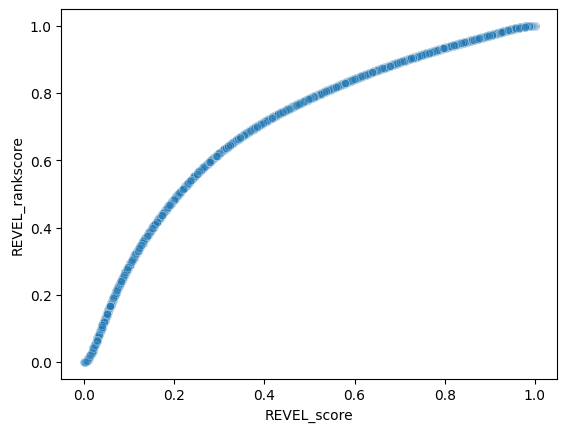

In [27]:
# What's the relationship between rankscore and score?
df_dbnsfp_clean_version["REVEL_rankscore"] = df_dbnsfp_clean_version.apply(lambda row: choose_version(row["REVEL_rankscore"], row["id_index"]), axis=1).replace(".", np.nan).astype(float)
sns.scatterplot(x=df_dbnsfp_clean_version["REVEL_score"].astype(float), y=df_dbnsfp_clean_version["REVEL_rankscore"].astype(float), alpha=0.3)

## Merge models and dbnsfp (can start from here and load clean dbNFSP file)

In [28]:
# Remember to also cast dbNSFP CHROM column to string for merging
df_dbnsfp_clean_version = pd.read_csv(dbnsfp_clean_file, dtype={"#CHROM": str})
print(df_dbnsfp_clean_version["BayesDel_noAF_score"].value_counts(dropna=False))
df_dbnsfp_clean_version.head()

/tmp/ipykernel_32174/3722250284.py:2: DtypeWarning: Columns (47,50,51,52,66,67,68,69,97,100,103,106,118,121,124,127,128,129,131,132,134,136,142,151,153,155,158,161,164,167,170,173,175,177,179,189,190,191,193,194,195,198,199,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,223,224,225,228,229,230,231,234,235,236,237,239,240,241,242,735,752,756,757,781,782,783,784,785,787,788,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,811,812,823,824,825,826,827,828,829,830,831,836) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dbnsfp_clean_version = pd.read_csv(dbnsfp_clean_file, dtype={"#CHROM": str})


 NaN         98
 0.292353     7
 0.286511     7
 0.236282     6
 0.552012     6
             ..
-0.382129     1
-0.539708     1
-0.330941     1
-0.563171     1
 0.803135     1
Name: BayesDel_noAF_score, Length: 60933, dtype: int64


,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,#Uploaded_variation,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,IMPACT,DISTANCE,STRAND,FLAGS,REFSEQ_MATCH,REFSEQ_OFFSET,GIVEN_REF,USED_REF,BAM_EDIT,HGVSc,HGVSp,HGVS_OFFSET,protein,AF_ESP,AF_EXAC,ALLELEID,CLNDISDB,CLNDN,CLNHGVS,CLNREVSTAT,CLNSIG,CLNSIGCONF,CLNVC,CLNVCSO,GENEINFO,MC,ORIGIN,RS,AF_TGP,CLNVI,CLNDISDBINCL,CLNDNINCL,CLNSIGINCL,mutant,EVH_epistatic,EVH_independent,ESM1V_ensemble_mean,Tranception,model_count,clinsig,protein_sequence,mutated_sequence,ClinSigSimple,aaref,aaalt,rs_dbSNP,hg19_chr,hg19_pos(1-based),hg18_chr,hg18_pos(1-based),aapos,genename,Ensembl_geneid,Ensembl_transcriptid,Ensembl_proteinid,Uniprot_acc,Uniprot_entry,HGVSc_ANNOVAR,HGVSp_ANNOVAR,HGVSc_snpEff,HGVSp_snpEff,HGVSc_VEP,HGVSp_VEP,APPRIS,GENCODE_basic,TSL,VEP_canonical,cds_strand,refcodon,codonpos,codon_degeneracy,Ancestral_allele,AltaiNeandertal,Denisova,VindijiaNeandertal,ChagyrskayaNeandertal,SIFT_score,SIFT_converted_rankscore,SIFT_pred,SIFT4G_score,SIFT4G_converted_rankscore,SIFT4G_pred,Polyphen2_HDIV_score,Polyphen2_HDIV_rankscore,Polyphen2_HDIV_pred,Polyphen2_HVAR_score,Polyphen2_HVAR_rankscore,Polyphen2_HVAR_pred,LRT_score,LRT_converted_rankscore,LRT_pred,LRT_Omega,MutationTaster_score,MutationTaster_converted_rankscore,MutationTaster_pred,MutationTaster_model,MutationTaster_AAE,MutationAssessor_score,MutationAssessor_rankscore,MutationAssessor_pred,FATHMM_score,FATHMM_converted_rankscore,FATHMM_pred,PROVEAN_score,PROVEAN_converted_rankscore,PROVEAN_pred,VEST4_score,VEST4_rankscore,MetaSVM_score,MetaSVM_rankscore,MetaSVM_pred,MetaLR_score,MetaLR_rankscore,MetaLR_pred,Reliability_index,MetaRNN_score,MetaRNN_rankscore,MetaRNN_pred,M-CAP_score,M-CAP_rankscore,M-CAP_pred,REVEL_score,REVEL_rankscore,MutPred_score,MutPred_rankscore,MutPred_protID,MutPred_AAchange,MutPred_Top5features,MVP_score,MVP_rankscore,gMVP_score,gMVP_rankscore,MPC_score,MPC_rankscore,PrimateAI_score,PrimateAI_rankscore,PrimateAI_pred,DEOGEN2_score,DEOGEN2_rankscore,DEOGEN2_pred,BayesDel_addAF_score,BayesDel_addAF_rankscore,BayesDel_addAF_pred,BayesDel_noAF_score,BayesDel_noAF_rankscore,BayesDel_noAF_pred,ClinPred_score,ClinPred_rankscore,ClinPred_pred,LIST-S2_score,LIST-S2_rankscore,LIST-S2_pred,VARITY_R_score,VARITY_R_rankscore,VARITY_ER_score,VARITY_ER_rankscore,VARITY_R_LOO_score,VARITY_R_LOO_rankscore,VARITY_ER_LOO_score,VARITY_ER_LOO_rankscore,Aloft_Fraction_transcripts_affected,Aloft_prob_Tolerant,Aloft_prob_Recessive,Aloft_prob_Dominant,Aloft_pred,Aloft_Confidence,CADD_raw,CADD_raw_rankscore,CADD_phred,CADD_raw_hg19,CADD_raw_rankscore_hg19,CADD_phred_hg19,DANN_score,DANN_rankscore,fathmm-MKL_coding_score,fathmm-MKL_coding_rankscore,fathmm-MKL_coding_pred,fathmm-MKL_coding_group,fathmm-XF_coding_score,fathmm-XF_coding_rankscore,fathmm-XF_coding_pred,Eigen-raw_coding,Eigen-raw_coding_rankscore,Eigen-phred_coding,Eigen-PC-raw_coding,Eigen-PC-raw_coding_rankscore,Eigen-PC-phred_coding,GenoCanyon_score,GenoCanyon_rankscore,integrated_fitCons_score,integrated_fitCons_rankscore,integrated_confidence_value,GM12878_fitCons_score,GM12878_fitCons_rankscore,GM12878_confidence_value,H1-hESC_fitCons_score,H1-hESC_fitCons_rankscore,H1-hESC_confidence_value,HUVEC_fitCons_score,HUVEC_fitCons_rankscore,HUVEC_confidence_value,LINSIGHT,LINSIGHT_rankscore,GERP++_NR,GERP++_RS,GERP++_RS_rankscore,phyloP100way_vertebrate,phyloP100way_vertebrate_rankscore,phyloP470way_mammalian,phyloP470way_mammalian_rankscore,phyloP17way_primate,phyloP17way_primate_rankscore,phastCons100way_vertebrate,phastCons100way_vertebrate_rankscore,phastCons470way_mammalian,phastCons470way_mammalian_rankscore,phastCons17way_primate,phastCons17way_primate_rankscore,SiPhy_29way_pi,SiPhy_29way_logOdds,SiPhy_29way_logOdds_rankscore,bStatistic,bStatistic_converted_rankscore,1000Gp3_AC,1000Gp3_AF,1000Gp3_AFR_AC,1000Gp3_AFR_AF,1000Gp3_EUR_AC,1000Gp3_EUR_AF,1000Gp3_AMR_AC,1000Gp3_AMR_AF,1000Gp3_EAS_A

In [29]:
columns_in_common = list(set(df_dbnsfp_clean_version.columns).intersection(set(df_merged.columns)))
print("columns in common: ", columns_in_common)
df_models_dbnsfp = df_dbnsfp_clean_version.merge(df_merged, on=columns_in_common, how='outer')
df_models_dbnsfp

columns in common:  ['Existing_variation', 'Consequence', 'CLNSIGCONF', 'EVH_epistatic', 'USED_REF', 'QUAL', 'protein', 'Allele', 'Codons', 'IMPACT', 'HGVSc', 'FLAGS', 'RS', 'GENEINFO', 'ClinSigSimple', 'CLNDNINCL', 'CLNVC', 'DISTANCE', 'CLNREVSTAT', 'CLNSIG', 'Feature_type', 'Protein_position', 'AF_ESP', 'CLNDN', 'model_count', 'REFSEQ_MATCH', '#CHROM', 'ID', 'CLNDISDB', 'mutant', 'mutated_sequence', 'clinsig', 'cDNA_position', 'ESM1V_ensemble_mean', 'ALT', 'POS', 'CLNHGVS', 'Feature', 'EVH_independent', 'CLNVCSO', 'BAM_EDIT', 'HGVS_OFFSET', 'Location', 'HGVSp', 'Gene', 'STRAND', '#Uploaded_variation', 'AF_EXAC', 'REF', 'ALLELEID', 'CDS_position', 'Amino_acids', 'MC', 'ORIGIN', 'CLNDISDBINCL', 'CLNSIGINCL', 'FILTER', 'CLNVI', 'Tranception', 'protein_sequence', 'REFSEQ_OFFSET', 'GIVEN_REF', 'AF_TGP']


#CHROM        POS      ID REF ALT QUAL FILTER  #Uploaded_variation  \
0           1    1020183  387476   G   C    .   PASS               387476   
1           1    1020297  774056   A   C    .   PASS               774056   
2           1    1022225  243036   G   A    .   PASS               243036   
3           1    1022383  541203   C   G    .   PASS               541203   
4           1    1035307  474141   C   T    .   PASS               474141   
...       ...        ...     ...  ..  ..  ...    ...                  ...   
106167      X  154863124   10319   C   T    .   PASS                10319   
106168      X  154863125   10318   G   A    .   PASS                10318   
106169      X  154863151   10315   C   T    .   PASS                10315   
106170      X  154863220  627110   A   G    .   PASS               627110   
106171      X  154863223  627109   A   C    .   PASS               627109   

           Location Allele    Gene      Feature Feature_type  \
0         1:1020183      C  375790  NM_198576.4   Transcript   
1         1:1020297      C  375790  NM_198576.4   Transcript   
2         1:1022225      A  375790  NM_198576.4   Transcript   
3         1:1022383      G  375790  NM_198576.4   Transcript   
4         1:1035307      T  375790  NM_198576.4   Transcript   
...             ...    ...     ...          ...          ...   
106167  X:154863124      T    2157  NM_019863.3   Transcript   
106168  X:154863125      A    2157  NM_019863.3   Transcript   
106169  X:154863151      T    2157  NM_019863.3   Transcript   
106170  X:154863220      G    2157  NM_019863.3   Transcript   
106171  X:154863223      C    2157  NM_019863.3   Transcript   

             Consequence  cDNA_position  CDS_position  Protein_position  \
0       missense_variant             64            11                 4   
1       missense_variant            178           125                42   
2       missense_variant            279           226                76   
3       missense_variant            437           384               128   
4       missense_variant            547           494               165   
...                  ...            ...           ...               ...   
106167  missense_variant            288           128                43   
106168  missense_variant            287           127                43   
106169  missense_variant            261           101                34   
106170  missense_variant            192            32                11   
106171  missense_variant            189            29                10   

       Amino_acids   Codons Existing_variation    IMPACT DISTANCE  STRAND  \
0              R/P  cGg/cCg                  -  MODERATE        -       1   
1              E/A  gAg/gCg                  -  MODERATE        -       1   
2              G/S  Ggc/Agc                  -  MODERATE        -       1   
3              H/Q  caC/caG                  -  MODERATE        -       1   
4              P/L  cCt/cTt                  -  MODERATE        -       1   
...            ...      ...                ...       ...      ...     ...   
106167         R/H  cGc/cAc                  -  MODERATE        -      -1   
106168         R/C  Cgc/Tgc                  -  MODERATE        -      -1   
106169         R/H  cGt/cAt                  -  MODERATE        -      -1   
106170         F/S  tTt/tCt                  -  MODERATE        -      -1   
106171         F/C  tTc/tGc                  -  MODERATE        -      -1   

       FLAGS REFSEQ_MATCH REFSEQ_OFFSET GIVEN_REF USED_REF BAM_EDIT  \
0          -            -             -         G        G        -   
1          -            -             -         A        A        -   
2          -            -             -         G        G        -   
3          -            -             -         C        C        -   
4          -            -             -         C        C        -   
...      ...          ...           ...       ...      ...   

In [308]:
df_models_dbnsfp.to_csv(merged_models_file, index=False)

## Remove duplicates

In [30]:
print("df_clinvar duplicates: ['#CHROM', 'POS', 'REF', 'ALT']:", df_clinvar.duplicated(subset=["#CHROM", "POS", "REF", "ALT"]).sum())
print("dbNSFP duplicates: ['#CHROM', 'POS', 'REF', 'ALT']:", df_dbnsfp.duplicated(subset=["#CHROM", "POS", "REF", "ALT"]).sum()) # 647 rows are originally duplicated
print("dbNSFP after filtering duplicates and mapping: ['#CHROM', 'POS', 'REF', 'ALT']:", df_dbnsfp_clean_version.duplicated(subset=["#CHROM", "POS", "REF", "ALT"]).sum()) # 551 after filtering duplicates and mapping
print("ProteinGym models + dbNSFP duplicates: ['#CHROM', 'POS', 'REF', 'ALT']:", df_models_dbnsfp.duplicated(subset=["#CHROM", "POS", "REF", "ALT"]).sum())
print("ProteinGym models + dbNSFP: ['protein', 'mutant']:", df_models_dbnsfp.duplicated(subset=["protein", "mutant"]).sum()) # 4390 duplicates - that's a ton. We should average this out.

df_clinvar duplicates: ['#CHROM', 'POS', 'REF', 'ALT']: 158
dbNSFP duplicates: ['#CHROM', 'POS', 'REF', 'ALT']: 5
dbNSFP after filtering duplicates and mapping: ['#CHROM', 'POS', 'REF', 'ALT']: 151
ProteinGym models + dbNSFP duplicates: ['#CHROM', 'POS', 'REF', 'ALT']: 43055
ProteinGym models + dbNSFP: ['protein', 'mutant']: 43392


In [31]:
max_unique_counts = df_models_dbnsfp.groupby(["protein", "mutant"]).nunique().max()
print("Columns with no protein,mutant duplicates: ", max_unique_counts[max_unique_counts == 1])
print("Columns with protein,mutant duplicates: ", max_unique_counts[max_unique_counts > 1])

Columns with no protein,mutant duplicates:  #CHROM           1
QUAL             1
FILTER           1
Gene             1
Feature          1
                ..
HGVSp_protein    1
id_index         1
ESM1b            1
GEMME            1
TranceptEVE      1
Length: 68, dtype: int64
Columns with protein,mutant duplicates:  POS                       2
ID                        3
REF                       2
ALT                       3
#Uploaded_variation       3
                         ..
MGI_mouse_gene            2
MGI_mouse_phenotype       2
max_number_semicolons     2
Unnamed: 0               32
EVE                       3
Length: 781, dtype: int64


In [32]:
# This averages over columns like position, and then also throws away the string columns
df_models_dbnsfp.groupby(["protein", "mutant"]).mean().reset_index()

,protein,mutant,POS,ID,#Uploaded_variation,Gene,cDNA_position,CDS_position,Protein_position,STRAND,AF_ESP,AF_EXAC,ALLELEID,CLNSIGCONF,ORIGIN,AF_TGP,EVH_epistatic,EVH_independent,ESM1V_ensemble_mean,Tranception,model_count,SIFT_score,SIFT4G_score,Polyphen2_HDIV_score,Polyphen2_HVAR_score,LRT_score,MutationTaster_converted_rankscore,MutationAssessor_score,FATHMM_score,PROVEAN_score,VEST4_score,MetaRNN_score,REVEL_score,MutPred_score,gMVP_score,MPC_score,PrimateAI_score,DEOGEN2_score,BayesDel_addAF_score,BayesDel_noAF_score,ClinPred_score,LIST-S2_score,VARITY_R_LOO_score,VARITY_ER_LOO_score,CADD_raw,CADD_raw_rankscore,CADD_phred,DANN_score,phyloP100way_vertebrate,phyloP100way_vertebrate_rankscore,phastCons100way_vertebrate,phastCons100way_vertebrate_rankscore,id_index,max_number_semicolons,Unnamed: 0,ESM1b,EVE,GEMME,TranceptEVE
0,NP_000007.1,A113D,75733579.0,1510903.0,1510903.0,34.0,417.0,338.0,113.0,1.0,NaN,NaN,1465580.0,NaN,1.0,NaN,-6.302288,-3.798813,-11.579514,-0.030024,8.0,0.001,0.003,0.992,0.992,0.000000,0.81001,4.580,-6.77,-4.40,0.940,0.946925,0.953,NaN,NaN,NaN,0.732964,0.989605,0.576594,0.590461,0.999414,0.975436,0.980918,0.965005,3.893131,0.75054,26.300,0.997789,7.545,0.81074,1.000,0.71638,2.0,3.0,2106.0,-14.386,5.240479,-3.341154,-0.013958
1,NP_000007.1,A113T,75733578.0,1476742.0,1476742.0,34.0,416.0,337.0,113.0,1.0,NaN,NaN,1416807.0,NaN,1.0,NaN,-4.756713,-2.564532,-8.190040,-0.018903,8.0,0.003,0.011,0.922,0.464,0.000000,0.81001,3.295,-6.72,-2.84,0.890,0.905257,0.912,NaN,NaN,NaN,0.663940,0.980549,0.565759,0.574897,0.992781,0.983902,0.903284,0.881160,4.049560,0.80320,27.300,0.998909,9.535,0.97135,1.000,0.71638,2.0,3.0,2105.0,-10.437,3.853149,-1.289911,-0.009649
2,NP_000007.1,A136V,75734810.0,859752.0,859752.0,34.0,486.0,407.0,136.0,1.0,NaN,0.00004,824407.0,NaN,1.0,NaN,-6.201459,-1.231747,-6.687571,-0.018965,8.0,0.003,0.049,0.951,0.767,0.000000,0.81001,2.590,-6.49,-3.10,0.812,0.871395,0.836,NaN,NaN,NaN,0.599820,0.952932,0.180943,0.314284,0.698484,0.950105,0.920604,0.868321,4.191732,0.85186,28.600,0.999063,5.993,0.70289,1.000,0.71638,2.0,3.0,2111.0,-10.885,4.654175,-2.017227,-0.010342
3,NP_000007.1,A165T,75740004.0,2202774.0,2202774.0,34.0,572.0,493.0,165.0,1.0,NaN,NaN,1928424.0,NaN,1.0,NaN,-4.779724,-2.438646,-5.234213,-0.018564,8.0,0.016,0.026,0.187,0.332,0.000000,0.81001,2.065,-3.97,-3.36,0.724,0.844216,0.822,NaN,NaN,NaN,0.593804,0.940214,0.210863,0.240960,0.941918,0.914708,0.795098,0.615596,3.110499,0.54507,23.700,0.998008,8.005,0.88076,1.000,0.71638,2.0,3.0,2118.0,-8.879,2.235535,-0.633032,-0.006529
4,NP_000007.1,A205P,75745819.0,1455130.0,1455130.0,34.0,692.0,613.0,205.0,1.0,NaN,NaN,1441616.0,NaN,1.0,NaN,-9.307317,-8.388903,-12.049829,-0.038814,8.0,0.001,0.002,0.999,0.976,0.000000,0.81001,4.170,-4.51,-4.60,0.940,0.970753,0.961,NaN,NaN,NaN,0.639557,0.982913,0.553084,0.556690,0.998052,0.987701,0.991976,0.967210,4.037695,0.79914,27.300,0.997349,4.818,0.62347,1.000,0.71638,2.0,3.0,2127.0,-16.425,13.721436,-7.223632,-0.027493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62775,NP_998885.1,R15L,23767591.0,180220.0,180220.0,400916.0,142.0,44.0,15.0,-1.0,NaN,NaN,178407.0,NaN,1.0,NaN,-4.329017,-4.275297,-7.314487,-0.055034,8.0,0.013,0.019,NaN,NaN,0.094042,0.81001,NaN,0.77,-2.10,0.744,0.633574,0.711,0.315,0.385219,NaN,0.840361,0.029194,-0.042084,-0.298228,0.805797,0.676632,NaN,NaN,2.964164,0.51261,23.300,0.983031,0.295,0.18821,0.006,0.17386,1.0,1.0,60025.5,-9.697,5.338280,-1.534270,-0.033858
62776,NP_998885.1,S59L,23767459.0,140745.0,140745.0,400916.0,274.0,176.0,59.0,-1.0,NaN,NaN,150458.0,NaN,1.0,NaN,-5.627983,-5.925066,-13.753598,-0.130915,8.0,0.001,0.001,NaN,NaN,0.000003,0.81001,NaN,0.22,-5.60,0.951,0.912427,0.810,0.457,0.799155,NaN,0.837060,0.502935,0.302050,0.196098,0.999366,0.931507,NaN,NaN,4.417224,0.90339,31.000,0.998737,7.641,0

In [33]:
# Step 1: Identify data types
# TODO include POS, ID, REF, ALT as strings here, and just choose the first one, or we could concat values together into a longer string (like with the dbNSFP scores)
numeric_cols = df_models_dbnsfp.select_dtypes(include=['number']).columns
string_cols = df_models_dbnsfp.select_dtypes(include=['object']).columns

# Step 2: Deduplicate numeric columns by taking the mean
numeric_df = df_models_dbnsfp[numeric_cols.to_list() + ["protein", "mutant"]].groupby(["protein", "mutant"]).mean().reset_index()

# Step 3: Deduplicate string columns by taking unique values
string_df = df_models_dbnsfp[string_cols].groupby(["protein", "mutant"]).first().reset_index()
string_df = string_df[[c for c in string_df if c in max_unique_counts[max_unique_counts == 1].index]]  # Only choose values that remain the same (simple)
assert len(string_df) == len(numeric_df)

df_models_dbnsfp_averaged = pd.concat([string_df, numeric_df], axis=1)
df_models_dbnsfp_averaged

,#CHROM,QUAL,FILTER,Feature,Feature_type,Consequence,Amino_acids,Existing_variation,IMPACT,DISTANCE,FLAGS,REFSEQ_MATCH,REFSEQ_OFFSET,BAM_EDIT,HGVSp,HGVS_OFFSET,CLNVC,CLNVCSO,GENEINFO,MC,CLNDISDBINCL,CLNDNINCL,CLNSIGINCL,protein_sequence,mutated_sequence,ClinSigSimple,hg19_chr,hg18_chr,GM12878_fitCons_score,GM12878_fitCons_rankscore,GM12878_confidence_value,HUVEC_confidence_value,LINSIGHT,LINSIGHT_rankscore,Pathway(Uniprot),Pathway(BioCarta)_short,Pathway(BioCarta)_full,Pathway(KEGG)_id,Pathway(KEGG)_full,Known_rec_info,SORVA_LOF_MAF0.005_HomOrCompoundHet,SORVA_LOF_MAF0.001_HomOrCompoundHet,ZFIN_zebrafish_gene,ZFIN_zebrafish_structure,ZFIN_zebrafish_phenotype_quality,ZFIN_zebrafish_phenotype_tag,HGVSp_protein,protein,mutant,POS,ID,#Uploaded_variation,Gene,cDNA_position,CDS_position,Protein_position,STRAND,AF_ESP,AF_EXAC,ALLELEID,CLNSIGCONF,ORIGIN,AF_TGP,EVH_epistatic,EVH_independent,ESM1V_ensemble_mean,Tranception,model_count,SIFT_score,SIFT4G_score,Polyphen2_HDIV_score,Polyphen2_HVAR_score,LRT_score,MutationTaster_converted_rankscore,MutationAssessor_score,FATHMM_score,PROVEAN_score,VEST4_score,MetaRNN_score,REVEL_score,MutPred_score,gMVP_score,MPC_score,PrimateAI_score,DEOGEN2_score,BayesDel_addAF_score,BayesDel_noAF_score,ClinPred_score,LIST-S2_score,VARITY_R_LOO_score,VARITY_ER_LOO_score,CADD_raw,CADD_raw_rankscore,CADD_phred,DANN_score,phyloP100way_vertebrate,phyloP100way_vertebrate_rankscore,phastCons100way_vertebrate,phastCons100way_vertebrate_rankscore,id_index,max_number_semicolons,Unnamed: 0,ESM1b,EVE,GEMME,TranceptEVE
0,1,.,PASS,NM_000016.6,Transcript,missense_variant,A/D,-,MODERATE,-,-,-,-,-,NP_000007.1:p.Ala113Asp,-,single_nucleotide_variant,SO:0001483,ACADM:34,"SO:0001583|missense_variant,SO:0001627|intron_...",None,None,None,MAAGFGRCCRVLRSISRFHWRSQHTKANRQREPGLGFSFEFTEQQK...,MAAGFGRCCRVLRSISRFHWRSQHTKANRQREPGLGFSFEFTEQQK...,Pathogenic,1,1,0.724815,0.89359,0,0,.,.,PATHWAY: Lipid metabolism; mitochondrial fatty...,.,.,hsa00071;hsa00280;hsa00410;hsa00640;hsa03320,"Fatty acid metabolism;Valine, leucine and isol...",recessive,0.0,0.0,.,.,.,.,p.Ala113Asp,NP_000007.1,A113D,75733579.0,1510903.0,1510903.0,34.0,417.0,338.0,113.0,1.0,NaN,NaN,1465580.0,NaN,1.0,NaN,-6.302288,-3.798813,-11.579514,-0.030024,8.0,0.001,0.003,0.992,0.992,0.000000,0.81001,4.580,-6.77,-4.40,0.940,0.946925,0.953,NaN,NaN,NaN,0.732964,0.989605,0.576594,0.590461,0.999414,0.975436,0.980918,0.965005,3.893131,0.75054,26.300,0.997789,7.545,0.81074,1.000,0.71638,2.0,3.0,2106.0,-14.386,5.240479,-3.341154,-0.013958
1,1,.,PASS,NM_000016.6,Transcript,missense_variant,A/T,-,MODERATE,-,-,-,-,-,NP_000007.1:p.Ala113Thr,-,single_nucleotide_variant,SO:0001483,ACADM:34,"SO:0001583|missense_variant,SO:0001627|intron_...",None,None,None,MAAGFGRCCRVLRSISRFHWRSQHTKANRQREPGLGFSFEFTEQQK...,MAAGFGRCCRVLRSISRFHWRSQHTKANRQREPGLGFSFEFTEQQK...,Pathogenic,1,1,0.724815,0.89359,0,0,.,.,PATHWAY: Lipid metabolism; mitochondrial fatty...,.,.,hsa00071;hsa00280;hsa00410;hsa00640;hsa03320,"Fatty acid metabolism;Valine, leucine and isol...",recessive,0.0,0.0,.,.,.,.,p.Ala113Thr,NP_000007.1,A113T,75733578.0,1476742.0,1476742.0,34.0,416.0,337.0,113.0,1.0,NaN,NaN,1416807.0,NaN,1.0,NaN,-4.756713,-2.564532,-8.190040,-0.018903,8.0,0.003,0.011,0.922,0.464,0.000000,0.81001,3.295,-6.72,-2.84,0.890,0.905257,0.912,NaN,NaN,NaN,0.663940,0.980549,0.565759,0.574897,0.992781,0.983902,0.903284,0.881160,4.049560,0.80320,27.300,0.998909,9.535,0.97135,1.000,0.71638,2.0,3.0,2105.0,-10.437,3.853149,-1.289911,-0.009649
2,1,.,PASS,NM_000016.6,Transcript,missense_variant,A/V,-,MODERATE,-,-,-,-,-,NP_000007.1:p.Ala136Val,-,single_nucleotide_variant,SO:0001483,ACADM:34,"SO:0001583|missense_variant,SO:0001627|intron_...",None,None,None,MAAGFGRCCRVLRSISRFHWRSQHTKANRQREPGLGFSFEFTEQQK...,MAAGFGRCCRVLRSISRFHWRSQHTKANRQREPGLGFSFEFTEQQK...,Pathogenic,1,1,0.724815,0.89359,0,0,.,.,PATHWAY: Lipid metabolism; mitochondrial fatty...,.,.,hsa00071;hsa00280;hsa00410;hsa00640;hsa03320,"Fatty acid metabolism;Valine, leucine and isol..

In [313]:
df_models_dbnsfp_averaged.to_csv(merged_models_deduplicated, index=False)

## Compute stats (can run notebook from here)

In [4]:
df_models_dbnsfp_averaged = pd.read_csv(merged_models_deduplicated)

In [5]:
# Quick check, let's make sure that each of the proteins at this point have >1 Pathogenic and >1 Benign
assert df_models_dbnsfp_averaged["ClinSigSimple"].nunique() == 2
# None of the proteins have just one class:
assert df_models_dbnsfp_averaged.groupby("protein").apply(lambda group: group["ClinSigSimple"].nunique() == 1).sum() == 0

In [6]:
all_model_cols = db_nsfp_models + list(new_model_cols.values())

#TODO this takes 2 minutes, could speed up by doing column-wise calculations
# Note: Concat RefSeq IDs together, see below:
def get_metrics(group):
    if group["ClinSigSimple"].nunique() == 1:
        return np.nan
    di = {}
    
    if group["protein"].nunique() > 1:
        di["protein"] = ";".join(group["protein"].unique())
    else:
        di["protein"] = group["protein"].unique()[0]
    di["num_variants"] = len(group)  # Useful to compare num_preds to num_variants
    for model in all_model_cols:
        subset = group[group[model].notna()]
        di[f"num_preds_{model}"] = len(subset)
        if len(subset) == 0 or subset["ClinSigSimple"].nunique() == 1:
            di[f"AUC_{model}"] = np.nan
            continue
        scores = subset[model]
        if model in score_directionality_flip or (model in new_model_cols.values() and model != "EVE"):
            scores = -1.0 * scores
        auc = roc_auc_score(y_true=subset["ClinSigBinary"], y_score=scores)
        di[f"AUC_{model}"] = auc
    return pd.Series(di)
        
df_models_dbnsfp_averaged["ClinSigBinary"] = df_models_dbnsfp_averaged["ClinSigSimple"].apply(lambda s: 1 if s == "Pathogenic" else 0)
# df_scores = df_models_dbnsfp_averaged.groupby("protein_sequence").progress_apply(get_metrics)  # Note: Average over protein sequence, not over protein (RefSeq ID)
# Concat together in case of multiple RefSeq IDs - it's a headache to use downstream but will be precise 
#  (rather than arbitrarily choosing one and getting confused later)
# df_scores = df_scores.reset_index().set_index("protein")

from multiprocessing import Pool, cpu_count

def applyParallel(dfGrouped, func):
    with Pool(8) as p:  # cpu_count()
        ret_list = list(tqdm(p.imap(func, [group for name, group in dfGrouped])))
    return ret_list
ret_list = applyParallel(df_models_dbnsfp_averaged.groupby("protein_sequence"), get_metrics)
df_scores = pd.DataFrame.from_records(ret_list)
df_scores

0it [00:00, ?it/s]

,protein,num_variants,num_preds_MetaRNN_score,AUC_MetaRNN_score,num_preds_SIFT4G_score,AUC_SIFT4G_score,num_preds_REVEL_score,AUC_REVEL_score,num_preds_BayesDel_addAF_score,AUC_BayesDel_addAF_score,num_preds_BayesDel_noAF_score,AUC_BayesDel_noAF_score,num_preds_PrimateAI_score,AUC_PrimateAI_score,num_preds_ClinPred_score,AUC_ClinPred_score,num_preds_VARITY_R_LOO_score,AUC_VARITY_R_LOO_score,num_preds_VARITY_ER_LOO_score,AUC_VARITY_ER_LOO_score,num_preds_gMVP_score,AUC_gMVP_score,num_preds_VEST4_score,AUC_VEST4_score,num_preds_CADD_phred,AUC_CADD_phred,num_preds_Polyphen2_HDIV_score,AUC_Polyphen2_HDIV_score,num_preds_Polyphen2_HVAR_score,AUC_Polyphen2_HVAR_score,num_preds_DEOGEN2_score,AUC_DEOGEN2_score,num_preds_SIFT_score,AUC_SIFT_score,num_preds_PROVEAN_score,AUC_PROVEAN_score,num_preds_MutationAssessor_score,AUC_MutationAssessor_score,num_preds_MPC_score,AUC_MPC_score,num_preds_MutPred_score,AUC_MutPred_score,num_preds_LIST-S2_score,AUC_LIST-S2_score,num_preds_DANN_score,AUC_DANN_score,num_preds_LRT_score,AUC_LRT_score,num_preds_FATHMM_score,AUC_FATHMM_score,num_preds_MutationTaster_converted_rankscore,AUC_MutationTaster_converted_rankscore,num_preds_ESM1b,AUC_ESM1b,num_preds_EVE,AUC_EVE,num_preds_TranceptEVE,AUC_TranceptEVE,num_preds_GEMME,AUC_GEMME
0,NP_001291646.4,174,143,1.000000,143,1.000000,143,0.992958,143,1.000000,143,0.950704,140,0.942446,143,1.000000,143,1.000000,143,1.000000,143,1.000000,143,1.000000,143,1.000000,143,0.992958,143,0.992958,143,1.000000,143,1.000000,143,1.000000,140,1.000000,140,1.000000,140,NaN,143,0.915493,143,0.978873,143,0.978873,143,0.690141,143,0.985915,174,0.998289,174,0.914457,174,0.974337,174,0.999145
1,NP_001104262.1,197,197,0.977118,197,0.707216,197,0.953757,197,0.960834,197,0.934972,197,0.946254,197,0.987229,0,NaN,0,NaN,197,0.971903,197,0.932631,197,0.932152,197,0.869519,197,0.902778,0,NaN,197,0.817582,197,0.907993,0,NaN,0,NaN,2,1.000000,197,0.805396,197,0.919221,197,0.901181,197,0.930609,197,0.841156,197,0.915390,197,0.932418,197,0.955407,197,0.944817
2,NP_004357.3,24,24,1.000000,24,0.887500,24,0.975000,24,1.000000,24,0.962500,24,1.000000,24,1.000000,24,0.950000,24,0.962500,24,0.987500,24,0.962500,24,0.950000,24,0.950000,24,0.925000,24,1.000000,24,0.925000,24,0.887500,24,0.950000,24,0.912500,9,1.000000,24,0.900000,24,0.950000,24,0.925000,24,0.875000,24,0.600000,24,0.950000,24,1.000000,24,1.000000,24,1.000000
3,NP_004270.2,7,7,1.000000,7,1.000000,7,1.000000,7,1.000000,7,1.000000,7,1.000000,7,1.000000,7,1.000000,7,1.000000,7,1.000000,7,1.000000,7,1.000000,7,1.000000,7,1.000000,7,1.000000,7,1.000000,7,1.000000,7,1.000000,7,1.000000,1,NaN,7,1.000000,7,1.000000,7,0.833333,7,1.000000,7,0.916667,7,1.000000,7,1.000000,7,1.000000,7,1.000000
4,NP_055134.2,16,16,0.928571,16,0.107143,16,0.392857,16,0.785714,16,0.428571,16,0.607143,16,0.892857,16,0.500000,16,0.464286,16,0.500000,16,0.607143,16,0.321429,16,0.357143,16,0.464286,16,0.178571,16,0.107143,16,0.428571,16,0.428571,0,NaN,9,0.428571,16,0.285714,16,0.357143,16,0.750000,16,0.071429,16,0.625000,16,0.678571,16,0.464286,16,0.464286,16,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2520,NP_065069.1,3,3,0.500000,3,0.500000,3,0.500000,3,1.000000,3,1.000000,3,0.500000,3,0.500000,3,0.500000,3,0.500000,3,0.500000,3,0.500000,3,1.000000,3,0.500000,3,0.500000,3,0.500000,3,0.500000,3,0.500000,3,0.500000,3,0.500000,2,0.000000,0,NaN,3,0.500000,3,0.750000,0,NaN,3,0.750000,3,1.000000,3,1.000000,3,1.000000,3,1.000000
2521,NP_000162.2,37,37,1.000000,37,0.980769,37,1.000000,37,1.000000,37,0.983974,37,0.820513,37,1.000000,0,NaN,0,NaN,0,NaN,37,0.990385,37,0.959936,37,0.846154,37,0.894231,0,NaN,37,0.985577,37,0.977564,28,1.000000,0,NaN,20,1.000000,37,0.926282,37,0.817308,37,0.722756,37,0.729167,37,0.775641,37,0.993590,37,1.000000,37,1.000000,37,1.000000
2522,NP_00

# Check missing predictions

Is it possible that some proteins don't have both pathogenic and benign? (necessary for AUC)

In [37]:
for model in ["EVE", "TranceptEVE", "ESM1b", "BayesDel_noAF_score"]:  # BayesDel_noAF_score and CADD seem to have the fewest missing values in the total variants df (only missing ~5 proteins)
    print(f"{model} number of proteins with no predictions: {(df_scores[f'num_preds_{model}'] == 0).sum()}/{len(df_scores)}")
    if (df_scores[f'num_preds_{model}'] == 0).sum() > 0:
        print(f"Example: {df_scores[df_scores[f'num_preds_{model}'] == 0].index[0]}")

EVE number of proteins with no predictions: 0/2525
TranceptEVE number of proteins with no predictions: 0/2525
ESM1b number of proteins with no predictions: 0/2525
BayesDel_noAF_score number of proteins with no predictions: 18/2525
Example: 569


In [15]:
# Check worst coverage
df_scores[[c for c in df_scores.columns if c.startswith("num_preds")]].apply(lambda col: col == df_scores["num_variants"]).sum().sort_values(ascending=True)

num_preds_MutPred_score                          102
num_preds_MPC_score                             1479
num_preds_gMVP_score                            1551
num_preds_VARITY_R_LOO_score                    1765
num_preds_VARITY_ER_LOO_score                   1765
num_preds_LIST-S2_score                         1793
num_preds_MutationAssessor_score                1822
num_preds_DEOGEN2_score                         1858
num_preds_Polyphen2_HVAR_score                  1958
num_preds_Polyphen2_HDIV_score                  1958
num_preds_FATHMM_score                          2079
num_preds_SIFT_score                            2093
num_preds_REVEL_score                           2102
num_preds_PROVEAN_score                         2109
num_preds_LRT_score                             2113
num_preds_VEST4_score                           2212
num_preds_SIFT4G_score                          2291
num_preds_PrimateAI_score                       2346
num_preds_EVE                                 

In [10]:
df_scores.to_csv(clinical_scores_file, index=False)

In [38]:
# df_scores = pd.read_csv(clinical_scores_file)
# Get overall stats
print(df_scores[[c for c in df_scores.columns if c.startswith("AUC")]].mean().sort_values(ascending=False))
print("\nAverage number of predictions per gene")
print(df_scores[[c for c in df_scores.columns if not c.startswith("AUC")]].mean().sort_values(ascending=False))
print("\nNumber of genes with AUC values")
print(df_scores[[c for c in df_scores.columns if c.startswith("AUC")]].notna().sum().sort_values(ascending=False))
print("\nNumber of genes with >0 predictions")
print((df_scores[[c for c in df_scores.columns if c.startswith("num_preds")]] > 0).sum().sort_values(ascending=False))
print("\nNumber of genes with all variants scored")
print(df_scores[[c for c in df_scores.columns if c.startswith("num_preds")]].apply(lambda col: col == df_scores["num_variants"]).sum().sort_values(ascending=False))

AUC_ClinPred_score                        0.980839
AUC_MetaRNN_score                         0.977012
AUC_BayesDel_addAF_score                  0.972027
AUC_VEST4_score                           0.929295
AUC_REVEL_score                           0.927518
AUC_BayesDel_noAF_score                   0.925151
AUC_VARITY_R_LOO_score                    0.920701
AUC_TranceptEVE                           0.919909
AUC_GEMME                                 0.919226
AUC_VARITY_ER_LOO_score                   0.917654
AUC_EVE                                   0.917019
AUC_gMVP_score                            0.914471
AUC_CADD_phred                            0.904843
AUC_Polyphen2_HVAR_score                  0.895855
AUC_DEOGEN2_score                         0.893757
AUC_ESM1b                                 0.891908
AUC_PROVEAN_score                         0.885751
AUC_MPC_score                             0.880611
AUC_Polyphen2_HDIV_score                  0.879419
AUC_SIFT_score                 

/tmp/ipykernel_32174/1874427895.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(df_scores[[c for c in df_scores.columns if not c.startswith("AUC")]].mean().sort_values(ascending=False))


## Clinical Ranking Table

In [39]:
model_type = {'TranceptEVE': 'Unsupervised',
    'EVE': 'Unsupervised',
    'ESM-1b': 'Unsupervised',
    'DEOGEN2': 'Supervised',
    'MutationAssessor': 'Unsupervised',
    'PROVEAN': 'Unsupervised',
    'SIFT': 'Unsupervised',
    'MutPred': 'Unsupervised',
    'CADD': 'Supervised',
    'MPC': 'Supervised',
    'PrimateAI': 'Unsupervised',
    'Polyphen2_HVAR': 'Supervised',
    'Polyphen2_HDIV': 'Supervised',
    'LIST-S2': 'Unsupervised',
    'FATHMM': 'Supervised',
    'LRT': 'Unsupervised',
    'DANN': 'Supervised',
    'MutationTaster': 'Supervised',
    "GEMME": "Unsupervised",
    # New models
    "ClinPred": "Supervised",
    "BayesDel (addAF)": "Supervised",
    "BayesDel (noAF)": "Supervised",
    "VARITY (ER)": "Supervised",
    "VARITY (R)": "Supervised",
    "REVEL": "Supervised",
    "PolyPhen2 (HDIV)": "Supervised",
    "PolyPhen2 (HVAR)": "Supervised",
    "gMVP": "Supervised",
    "VEST4": "Supervised",
    "MetaRNN": "Supervised",
    "SIFT4G": "Unsupervised",
}
model_rename = {
    "BayesDel_addAF": "BayesDel (addAF)",
    "BayesDel_noAF": "BayesDel (noAF)",
    "Polyphen2_HDIV": "PolyPhen2 (HDIV)",
    "Polyphen2_HVAR": "PolyPhen2 (HVAR)",
    "VARITY_ER_LOO": "VARITY (ER)",
    "VARITY_R_LOO": "VARITY (R)",
    "CADD_phred": "CADD",
    "TranceptEVE_L": "TranceptEVE",
    "ESM1b": "ESM-1b"
}

In [42]:
# Exclude some models
def latex_format(row):
    # Ranking, Model, Type, AUC
    return f"{row['ranking']} & {row['model']} & {row['model_type']} & {row['AUC']:.3f} \\\\"
df_ranking = df_scores[[c for c in df_scores.columns if c.startswith("AUC")]].mean().sort_values(ascending=False).copy()
df_ranking.name = "AUC"
df_ranking = df_ranking.reset_index(drop=False).rename(columns={"index": "model"})
df_ranking = df_ranking.reset_index(drop=False).rename(columns={"index": "ranking"})
df_ranking["ranking"] += 1
# Clean up model name
df_ranking["model"] = df_ranking["model"].apply(lambda s: s.strip().replace("AUC_", "").replace("_score", "").replace("_converted_rankscore", ""))
df_ranking["model"] = df_ranking["model"].apply(lambda s: model_rename.get(s, s))
# Add supervised / unsupervised
df_ranking["model_type"] = df_ranking["model"].apply(lambda s: model_type[s])
display(df_ranking)
df_ranking.round(3).to_csv("../2023_12_05_clinical_subs_AUC_ranking.csv",index=False)
# Get LaTex version
print("\n".join(df_ranking.apply(latex_format, axis=1)))

,ranking,model,AUC,model_type
0,1,ClinPred,0.980839,Supervised
1,2,MetaRNN,0.977012,Supervised
2,3,BayesDel (addAF),0.972027,Supervised
3,4,VEST4,0.929295,Supervised
4,5,REVEL,0.927518,Supervised
5,6,BayesDel (noAF),0.925151,Supervised
6,7,VARITY (R),0.920701,Supervised
7,8,TranceptEVE,0.919909,Unsupervised
8,9,GEMME,0.919226,Unsupervised
9,10,VARITY (ER),0.917654,Supervised


1 & ClinPred & Supervised & 0.981 \\
2 & MetaRNN & Supervised & 0.977 \\
3 & BayesDel (addAF) & Supervised & 0.972 \\
4 & VEST4 & Supervised & 0.929 \\
5 & REVEL & Supervised & 0.928 \\
6 & BayesDel (noAF) & Supervised & 0.925 \\
7 & VARITY (R) & Supervised & 0.921 \\
8 & TranceptEVE & Unsupervised & 0.920 \\
9 & GEMME & Unsupervised & 0.919 \\
10 & VARITY (ER) & Supervised & 0.918 \\
11 & EVE & Unsupervised & 0.917 \\
12 & gMVP & Supervised & 0.914 \\
13 & CADD & Supervised & 0.905 \\
14 & PolyPhen2 (HVAR) & Supervised & 0.896 \\
15 & DEOGEN2 & Supervised & 0.894 \\
16 & ESM-1b & Unsupervised & 0.892 \\
17 & PROVEAN & Unsupervised & 0.886 \\
18 & MPC & Supervised & 0.881 \\
19 & PolyPhen2 (HDIV) & Supervised & 0.879 \\
20 & SIFT & Unsupervised & 0.878 \\
21 & SIFT4G & Unsupervised & 0.877 \\
22 & MutationAssessor & Unsupervised & 0.877 \\
23 & MutPred & Unsupervised & 0.875 \\
24 & PrimateAI & Unsupervised & 0.855 \\
25 & LIST-S2 & Unsupervised & 0.842 \\
26 & MutationTaster & Supervi

In [ ]:
# Write out to file
# clinical_rankings_file